In [1]:
import sys
sys.path.append('..')

import numpy as np
import os
from time import time
from collections import Counter
import random
from matplotlib import pyplot as plt

from lib.data_utils import shuffle
#from lib.config import data_dir

def mnist():
    fd = open(os.path.join('train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trX = loaded[16:].reshape((60000,28*28)).astype(float)

    fd = open(os.path.join('train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trY = loaded[8:].reshape((60000))

    fd = open(os.path.join('t10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teX = loaded[16:].reshape((10000,28*28)).astype(float)

    fd = open(os.path.join('t10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teY = loaded[8:].reshape((10000))
    
    trY = np.asarray(trY)
    teY = np.asarray(teY)

    return trX, teX, trY, teY

def mnist_with_valid_set():
    trX, teX, trY, teY = mnist()

    trX, trY = shuffle(trX, trY)
    vaX = trX[50000:]
    vaY = trY[50000:]
    trX = trX[:50000]
    trY = trY[:50000]

    return trX, vaX, teX, trY, vaY, teY

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpglu2ei/265abc51f7c376c224983485238ff1a5.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpglu2ei/265abc51f7c376c224983485238ff1a5.exp

Using gpu device 0: Quadro K2000 (CNMeM is disabled, cuDNN 5005)
DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpfnes2h/97496c4d3cf9a06dc4082cc141f918d2.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmpfnes2h/97496c4d3cf9a06dc4082cc141f918d2.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-

In [2]:
#data_dir='/home/dcgan_code-master/mnist'
import theano
theano.config.floatX='float32'
theano.config.floatX

'float32'

In [3]:
trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()
import cv2
data2=np.zeros((1000,64*64))
trX=trX
%matplotlib inline
for i in range(1000):
    XXX=trX[i,:].reshape(28,28)
    temp=cv2.resize(XXX,(64,64))
    #temp[temp>=0.5]=1
    #temp[temp<=0.5]=0
    temp=temp.reshape(-1)
    data2[i,:]=np.round(temp/max(temp)*255.)

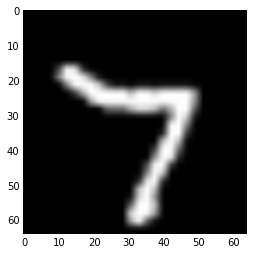

In [5]:
np.set_printoptions(threshold='nan')
plt.imshow(data2[0].reshape(64,64),'gray')
#plt.imshow(trX[0].reshape(28,28),'gray')

In [6]:
import numpy as np
import theano
import theano.tensor as tensor
from theano.tensor.signal.pool import pool_2d
from theano.tensor.nnet import conv2d

def conv( x, w, b=None ):
    s = int(np.floor(w.get_value().shape[-1]/2.))
    z = conv2d(x, w, border_mode='full')[:, :, s:-s, s:-s]
    if b is not None:
        z += b.dimshuffle('x', 0, 'x', 'x')
    
    return z
        
def max_pool( x, size, ignore_border=False ):
    return pool_2d( x, size, ignore_border=ignore_border )

def rectify( x ):
    return (x + abs(x)) / 2.0

def batchnorm( x, g=None, b=None, eps=1e-8 ):
    if x.ndim == 4:
        m = tensor.mean(x, axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')
        v = tensor.mean(tensor.sqr(x - m), 
                          axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')

        x = (x - m) / tensor.sqrt( v + eps )
        if g is not None and b is not None:
            x = x*g.dimshuffle('x', 0, 'x', 'x') + b.dimshuffle('x', 0, 'x', 'x')

    elif x.ndim == 2:
        m = tensor.mean(x, axis=0)
        v = tensor.mean(tensor.sqr(x - m), axis=0)

        x = (x - m) / tensor.sqrt( v + eps )
        if g is not None and b is not None:
            x = x*g + b

    return x

def depool( x, factor=2 ):
    """
    This code is from 
    https://gist.github.com/kastnerkyle/f3f67424adda343fef40
    """
    output_shape = [
        x.shape[1],
        x.shape[2]*factor,
        x.shape[3]*factor
    ]
    stride = x.shape[2]
    offset = x.shape[3]
    in_dim = stride * offset
    out_dim = in_dim * factor * factor

    upsamp_matrix = tensor.zeros((in_dim, out_dim))
    rows = tensor.arange(in_dim)
    cols = rows*factor + (rows/stride * factor * offset)
    upsamp_matrix = tensor.set_subtensor(upsamp_matrix[rows, cols], 1.)

    flat = tensor.reshape(x, (x.shape[0], output_shape[0], x.shape[2] * x.shape[3]))

    up_flat = tensor.dot(flat, upsamp_matrix)
    upsamp = tensor.reshape(up_flat, (x.shape[0], output_shape[0],
                                      output_shape[1], output_shape[2]))

    return upsamp

def full_conn( x, w, b=None ):
    return tensor.dot( x, w ) + b

def leaky_rectify( x, leak=0.2 ):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x) 

In [7]:
trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()
trX.shape

(50000L, 784L)

In [8]:
import scipy.io as sio
WB=sio.loadmat('WB_test56_3600.mat')['WB_small']
WB.shape

(3600L, 3136L)

In [26]:
import sys
sys.path.append('..')

import os
import json
from time import time
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.externals import joblib

import theano
import theano.tensor as T
from theano.sandbox.cuda.dnn import dnn_conv

from lib import activations
from lib import updates
from lib import inits
from lib.vis import grayscale_grid_vis
from lib.rng import py_rng, np_rng
from lib.ops import batchnorm, conv_cond_concat, deconv, dropout
from lib.theano_utils import floatX, sharedX
from lib.data_utils import OneHot, shuffle, iter_data
from lib.metrics import nnc_score, nnd_score

trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()

#trX=data2
#trX = trX_test
#import scipy.io as sio
#WB=sio.loadmat('WB_test28_GAN.mat')['WB_test28_GAN']

trX=WB
#vaX = floatX(vaX[0:1000])/255.

k = 1             # # of discrim updates for each gen update
l2 = 2.5e-5       # l2 weight decay
b1 = 0.5          # momentum term of adam
nc = 1            # # of channels in image
ny = 10           # # of classes
nbatch = 100      # # of examples in batch
npx = 56          # # of pixels width/height of images
nz = 100          # # of dim for Z
ngfc = 1024       # # of gen units for fully connected layers
ndfc = 1024       # # of discrim units for fully connected layers
ngf = 64          # # of gen filters in first conv layer
ndf = 64          # # of discrim filters in first conv layer
nx = npx*npx*nc   # # of dimensions in X
niter = 100       # # of iter at starting learning rate
niter_decay = 100 # # of iter to linearly decay learning rate to zero
lr = 0.0002       # initial learning rate for adam
ntrain, nval, ntest = len(trX), len(vaX), len(teX)

def transform(X):
    return (floatX(X)/1.).reshape(-1, nc, npx, npx)

def inverse_transform(X):
    X = X.reshape(-1, npx, npx)
    return X

relu = activations.Rectify()
sigmoid = activations.Sigmoid()
lrelu = activations.LeakyRectify()
bce = T.nnet.binary_crossentropy

gifn = inits.Normal(scale=0.02)
difn = inits.Normal(scale=0.02)
gain_ifn = inits.Normal(loc=1., scale=0.02)
bias_ifn = inits.Constant(c=0.)


gw  = gifn((nz, ngfc), 'gw')
gg = gain_ifn((ngfc), 'gg')
gb = bias_ifn((ngfc), 'gb')

gw2 = gifn((ngfc, ngf*2*14*14), 'gw2')
gg2 = gain_ifn((ngf*2*14*14), 'gg2')
gb2 = bias_ifn((ngf*2*14*14), 'gb2')

gw3 = gifn((ngf*2, ngf, 5, 5), 'gw3')
gg3 = gain_ifn((ngf), 'gg3')
gb3 = bias_ifn((ngf), 'gb3')

# gw4 = gifn((ngf*2, ngf, 5, 5), 'gw4')
# gg4 = gain_ifn((ngf), 'gg4')
# gb4 = bias_ifn((ngf), 'gb4')

gwx = gifn((ngf, nc, 5, 5), 'gwx')

dw  = difn((ndf, nc, 5, 5), 'dw')
# dg = gain_ifn((ndf), 'dg')
# db = bias_ifn((ndf), 'db')

dw2 = difn((ndf*2, ndf, 5, 5), 'dw2')
dg2 = gain_ifn((ndf*2), 'dg2')
db2 = bias_ifn((ndf*2), 'db2')

dw3 = difn((ndf*2*14*14, ndfc), 'dw3')
dg3 = gain_ifn((ndfc), 'dg3')
db3 = bias_ifn((ndfc), 'db3')

dwy = difn((ndfc, 1), 'dwy')

gen_params = [gw, gg, gb, gw2, gg2, gb2, gw3, gg3, gb3, gwx]
discrim_params = [dw,dw2,dg2,db2, dw3,dg3,db3, dwy]

def gen(Z, w, gg, gb, w2, gg2, gb2, w3, gg3, gb3, wx):
    h = relu(batchnorm(T.dot(Z, w),g=gg,b=gb))
    h2 = relu(batchnorm(T.dot(h, w2),g=gg2,b=gb2))
    h2 = h2.reshape((h2.shape[0], ngf*2, 14, 14))
    h3 = relu(batchnorm(deconv(h2, w3, subsample=(2, 2), border_mode=(2, 2)),g=gg3,b=gb3))
    #h4 = relu(batchnorm(deconv(h3, w4, subsample=(2, 2), border_mode=(2, 2)),g=gg4,b=gb4))
    x = sigmoid(deconv(h3, wx, subsample=(2, 2), border_mode=(2, 2)))
    return x

def discrim(X, w, w2, dg2, db2, w3, dg3, db3, wy):
    h = lrelu(dnn_conv(X, w, subsample=(2, 2), border_mode=(2, 2)))
    h2 = lrelu(batchnorm(dnn_conv(h, w2, subsample=(2, 2), border_mode=(2, 2)),g=dg2,b=db2))
    h2 = T.flatten(h2, 2)
    h3 = lrelu(batchnorm(T.dot(h2, w3), g=dg3,b=db3))
    y = sigmoid(T.dot(h3, wy))
    return y

X = T.tensor4()
Z = T.matrix()

gX = gen(Z, *gen_params)

p_real = discrim(X, *discrim_params)
p_gen = discrim(gX, *discrim_params)

d_cost_real = bce(p_real, T.ones(p_real.shape)).mean()
d_cost_gen = bce(p_gen, T.zeros(p_gen.shape)).mean()
g_cost_d = bce(p_gen, T.ones(p_gen.shape)).mean()

d_cost = d_cost_real + d_cost_gen
g_cost = g_cost_d

cost = [g_cost, d_cost, g_cost_d, d_cost_real, d_cost_gen]

lrt = sharedX(lr)
d_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
g_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
d_updates = d_updater(discrim_params, d_cost)
g_updates = g_updater(gen_params, g_cost)
updates = d_updates + g_updates

print 'COMPILING'
t = time()
_train_g = theano.function([X, Z], cost, updates=g_updates)
_train_d = theano.function([X, Z], cost, updates=d_updates)
_gen = theano.function([Z], gX)
print '%.2f seconds to compile theano functions'%(time()-t)

sample_zmb = floatX(np_rng.uniform(-1., 1., size=(200, nz)))


n_updates = 0
n_check = 0
n_epochs = 0
n_updates = 0
n_examples = 0
t = time()
for epoch in range(1, 5000):
    trX= shuffle(trX)
    for imb in tqdm(iter_data(trX, size=nbatch), total=ntrain/nbatch):
        imb = transform(imb)
        #ymb = floatX(OneHot(ymb, ny))
        zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
        if n_updates % (k+1) == 0:
            cost = _train_g(imb, zmb)
        else:
            cost = _train_d(imb, zmb)
        n_updates += 1
        n_examples += len(imb)
    #if (epoch-1) % 5 == 0:
    g_cost = float(cost[0])
    d_cost = float(cost[1])
    print g_cost, d_cost

COMPILING
28.12 seconds to compile theano functions


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.55it/s]


0.706974029541 1.41385579109


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


0.722019910812 1.3631632328


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.55it/s]


0.755596101284 1.32571709156


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


0.780821979046 1.26317691803


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.54it/s]


0.81557649374 1.21477913857


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


0.855313718319 1.21448993683


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.54it/s]


0.895852684975 1.21983504295


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


0.908009052277 1.17338180542


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


0.923621058464 1.14178109169


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


0.974219977856 1.0932161808


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


0.998993217945 1.04805731773


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.02803242207 1.04794979095


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.04265058041 1.01768803596


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.12040889263 1.0181081295


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.13286066055 1.03990340233


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.13617563248 0.963670492172


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.18065798283 0.94470846653


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.20373904705 0.891564667225


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.21452772617 0.884902477264


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.27884674072 0.917211472988


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.32585382462 0.846935927868


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.34860777855 0.85072863102


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


1.39159727097 0.810497283936


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.41253697872 0.850418746471


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.58838391304 0.897630035877


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.50684046745 0.836575746536


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.41177248955 0.747526705265


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.44521784782 0.717848062515


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.43993794918 0.63799238205


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.53461611271 0.606902360916


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.55276763439 0.544225394726


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.56042265892 0.65663254261


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.60066592693 0.617369234562


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.24128222466 1.03044509888


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.6383177042 0.636584877968


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.5973379612 0.705811500549


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.61608088017 0.572159528732


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.6592297554 0.588366508484


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.68771398067 0.600541710854


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.71587407589 0.501200437546


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.77699005604 0.486348628998


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.80284643173 0.525482058525


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


1.66872859001 0.543954193592


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


2.19547462463 0.791453421116


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.71963012218 0.559513926506


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.71522760391 0.586956560612


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


1.71254825592 0.528856635094


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


2.2409324646 0.795592188835


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


1.72090649605 0.45641797781


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.80471086502 0.445618927479


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.84291350842 0.415548324585


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


2.07616448402 0.591338217258


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.49391150475 0.861095905304


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.99373841286 0.523368299007


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.10733866692 0.478140205145


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.00328230858 0.346898972988


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.09120845795 0.422564893961


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.17072200775 0.51112896204


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.12835669518 0.421905606985


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.99352109432 0.381972640753


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


2.63566112518 0.640523374081


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.96292328835 0.408849477768


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.9577409029 0.41880863905


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.21223020554 0.504985690117


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.43057060242 0.533011138439


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.21110868454 0.542188286781


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.98179340363 0.439021527767


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.9388384819 0.370087742805


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.04330968857 0.439626336098


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


2.23859357834 0.43052148819


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.00767707825 0.37135130167


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.09058761597 0.351696491241


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.25835108757 0.297733098269


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.41477322578 0.382004737854


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.13991856575 0.302482247353


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.31998300552 0.353475391865


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.0829012394 0.351706206799


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.00154137611 0.501540780067


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.23540568352 0.487091362476


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.08088684082 0.538724780083


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


2.21882820129 0.48449575901


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.33364319801 0.468278050423


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.18364262581 0.502094566822


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.19434547424 0.362448871136


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


2.22530055046 0.330112040043


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.30769920349 0.33340960741


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.37044167519 0.458201527596


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.26856207848 0.394287884235


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


2.37096500397 0.405391275883


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.26288795471 0.422656834126


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.34406137466 0.328405529261


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


2.37460255623 0.411590993404


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.32729625702 0.40901350975


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.5111386776 0.431098222733


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


2.58568000793 0.496515154839


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.47431659698 0.53711616993


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.42366838455 0.464778006077


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


2.38905692101 0.472582101822


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.37896203995 0.395989269018


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.37227940559 0.411421209574


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.4648001194 0.561944544315


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.56202602386 0.399176895618


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.5290055275 0.379621148109


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.71782708168 0.562664628029


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.54962706566 0.420736432076


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.63942694664 0.445998311043


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.63034415245 0.41355574131


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.59875011444 0.312734097242


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.54it/s]


2.58570504189 0.322270035744


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.68208003044 0.443711936474


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.80481433868 0.413916409016


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.62984681129 0.357402861118


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.65654230118 0.384999036789


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.71372365952 0.249013662338


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.7272875309 0.303205788136


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.84975147247 0.455702841282


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.85156106949 0.298445701599


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.19284915924 0.398002564907


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


2.61823558807 0.312036156654


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.098508358 0.408968091011


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.78349637985 0.426349878311


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


2.79452586174 0.25808018446


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.87661075592 0.345415711403


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.99739480019 0.311360001564


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


2.66070485115 0.440023958683


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.65656805038 0.381169676781


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.92845082283 0.299678742886


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.9104309082 0.38726618886


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.85824108124 0.327913373709


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


2.88306760788 0.281251728535


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.97219109535 0.335155695677


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.96449589729 0.249113351107


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.99753570557 0.231281459332


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.08108091354 0.2950912714


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.9288122654 0.37716114521


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.06173157692 0.335248976946


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.97267079353 0.240431159735


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.08853030205 0.268754541874


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.27610898018 0.323517620564


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.15594911575 0.323607027531


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.97412848473 0.30664741993


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.15779852867 0.24453407526


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.1798043251 0.329320639372


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.14336252213 0.231863409281


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.49804759026 0.363416224718


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


3.91487360001 0.476052850485


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.15415120125 0.511147558689


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.25442814827 0.325123727322


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.02968144417 0.346498668194


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.35627269745 0.300034880638


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


3.48823547363 0.389757394791


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.17721223831 0.415577530861


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.14506173134 0.336510568857


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.19287776947 0.276386678219


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.08232355118 0.276779532433


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.13930797577 0.315436661243


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.06446218491 0.213822335005


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.08120298386 0.208286732435


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.10503721237 0.188232287765


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.15974140167 0.194826498628


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.18972706795 0.238241493702


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.20668935776 0.223329931498


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.38711357117 0.314722061157


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.27573370934 0.177159786224


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.26207327843 0.246065303683


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.35278558731 0.357699930668


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.69758081436 0.319662600756


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.44594597816 0.501094043255


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.3304297924 0.278728723526


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.52723908424 0.281218141317


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.19451761246 0.310220479965


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.40890169144 0.248606026173


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.51076173782 0.294835954905


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.47525978088 0.275301992893


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.89667701721 0.434477567673


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.82261538506 0.287650108337


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


3.03532600403 0.165310576558


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.41774654388 0.307141900063


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.46546030045 0.282613873482


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.17045283318 0.160454362631


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.31423473358 0.340100586414


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.84930849075 0.190468341112


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


2.94674015045 0.112873248756


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.93439269066 0.143443286419


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.75850558281 0.140285372734


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.95321774483 0.15906073153


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.58211064339 0.0991984903812


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.15229678154 0.115560382605


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.36065363884 0.0876938924193


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.20672297478 0.095113620162


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.38272309303 0.0834695994854


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.83748102188 0.0526907369494


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.24691295624 0.0747389942408


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


3.84930825233 0.082568988204


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.4813580513 0.0561368316412


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.57968616486 0.0630713105202


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.34427833557 0.0717441663146


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.17529320717 0.0686689913273


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


3.91559576988 0.0477520376444


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.59it/s]


3.78356599808 0.0409059897065


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.94593882561 0.0565755665302


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.0710978508 0.0417015962303


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.27300071716 0.0442345030606


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.86683678627 0.0344767235219


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.15993833542 0.0272149294615


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.45817422867 0.0259266383946


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.25470113754 0.0321918018162


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


3.88603329659 0.0375074781477


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


4.48406267166 0.0254879407585


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.82545900345 0.0488496683538


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.92619752884 0.0748660862446


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.16473245621 0.0326651148498


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.12940740585 0.036892991513


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


4.23100328445 0.0607000254095


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.54803752899 0.0259327478707


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.20700979233 0.0285068172961


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.32826185226 0.0355996824801


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.06492328644 0.0332963839173


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.21751451492 0.16201621294


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.53627681732 0.0551145151258


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


4.41522932053 0.0358281284571


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.74514341354 0.0324741229415


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


4.7870426178 0.0315029285848


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.70914363861 0.0218360982835


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.10080432892 0.0295982453972


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.18466663361 0.035923935473


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


4.57321071625 0.0242817364633


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.82517337799 0.0204149689525


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.92672252655 0.0214520804584


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.52667427063 0.0181904826313


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.65274906158 0.0232613347471


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.58208942413 0.021997988224


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.06423521042 0.0422149226069


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.70644187927 0.028958722949


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.68030261993 0.0201946422458


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.62827157974 0.0235998779535


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.3549656868 0.0254665035754


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.320997715 0.0317280553281


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.18028640747 0.0184110589325


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.65182352066 0.0216703601182


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


5.33932685852 0.0140597652644


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.83215713501 0.0171351730824


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.86515903473 0.0195253565907


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.65956735611 0.0298774726689


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.36625385284 0.0184055939317


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.81693553925 0.0170275699347


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.77076101303 0.0182914007455


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


4.64879512787 0.0184068474919


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.56448507309 0.0285827871412


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.96865558624 0.0188833065331


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.7095117569 0.0187518261373


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.06694030762 0.0166933462024


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.25042581558 0.0125641152263


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.37135124207 0.0104133561254


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.16114234924 0.0114391297102


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.73150777817 0.0151735749096


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.79846668243 0.0142457168549


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.10930347443 0.0116072213277


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.63476085663 0.00783519167453


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.07790660858 0.0132958572358


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.09705209732 0.011733815074


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.72091007233 0.0181201063097


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


5.40389537811 0.00917222723365


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.0677318573 0.0108543885872


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.30657243729 0.0103165283799


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.99954319 0.0117290010676


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.28431653976 0.0122772315517


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.92581176758 0.0136170927435


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.27377986908 0.0140107423067


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.09445238113 0.0153300175443


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.69077587128 0.0244252551347


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


5.82672262192 0.0232314895838


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.94923210144 0.0161523204297


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.791867733 0.0124702919275


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.99742746353 0.0319801680744


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.39767217636 3.80458426476


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.98567652702 1.62546205521


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.54541659355 2.19813156128


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.42571091652 1.81916666031


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.56635451317 1.10158956051


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.65513598919 1.17162334919


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


1.80167114735 0.745974063873


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.88505554199 0.812296748161


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.01012706757 0.472085177898


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.2508161068 0.525158882141


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.26032328606 0.338632553816


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.41690397263 0.322833478451


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.5682861805 0.27687472105


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.722905159 0.220384255052


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.84124827385 0.209903866053


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.98298168182 0.184652030468


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.08050513268 0.113380298018


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


3.28340768814 0.109439611435


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.07636404037 0.0838657170534


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.27853608131 0.072723634541


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.71853280067 0.117745041847


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.84252691269 0.0459450855851


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.59701299667 0.0719393789768


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.74679112434 0.0459876954556


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.90067386627 0.0361024625599


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.04752254486 0.059192083776


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.80390501022 0.085327476263


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.06238126755 0.0436935462058


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.72773170471 0.0813501179218


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.68834471703 0.0501838549972


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


3.98748970032 0.0705488324165


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.03569841385 0.0440155863762


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


4.05645465851 0.0426753237844


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.96680545807 0.0740398019552


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.55847215652 0.0526429899037


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.33010053635 0.058704007417


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


4.75259256363 0.0442107617855


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.17235422134 0.0581857673824


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.39032697678 0.0348974131048


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.20915317535 0.0309259481728


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.4838681221 0.0249586999416


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


5.04255390167 0.0199232939631


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.86405706406 0.0310080088675


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


5.13896036148 0.0331109762192


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


4.27634906769 0.0273003466427


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.33924198151 0.0286737419665


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.61348104477 0.0313726179302


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.67093038559 0.0312564782798


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


4.86602687836 0.0253266673535


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.06106853485 0.0193000491709


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.54it/s]


4.84068775177 0.0268862564117


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.18912124634 0.0168920662254


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.55346632004 0.0218137390912


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.80504131317 0.0210006460547


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


4.29303884506 0.0298287700862


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.08078432083 0.021963108331


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


4.83146715164 0.0201423820108


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.90858316422 0.0173673909158


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.21657371521 0.0161739755422


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.09335041046 0.0547232702374


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.73418807983 0.0311638750136


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.72362852097 0.0985556840897


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.67430925369 0.0474489033222


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.76647138596 0.0289168916643


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.78995704651 0.0249691344798


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.24521493912 0.0627770200372


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.0192027092 0.0277926437557


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.08409261703 0.0231486614794


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


4.87935400009 0.020166862756


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.13365983963 0.0274502560496


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.25380086899 0.0175280794501


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.06510782242 0.0246113762259


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


5.15251541138 0.0171635281295


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


5.62485218048 0.0252856425941


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.253657341 0.015686808154


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.21095705032 0.0485146120191


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.96173381805 0.0423560068011


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.14950942993 0.0268919300288


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


5.51632976532 0.024562433362


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.34958314896 0.0252185054123


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.40413045883 0.0173703320324


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.62317562103 0.0181494429708


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.6969127655 0.0209543965757


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.35692882538 0.0126744825393


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.13517808914 0.0977165997028


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.65927124023 0.0129174701869


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.36570596695 0.0113883493468


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.05880641937 0.0130075374618


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.91022157669 0.0195111427456


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


5.0494146347 0.194331869483


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.21867799759 0.0329465083778


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.44593000412 0.0123006813228


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.9348487854 0.0195599775761


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.3209900856 0.268262803555


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.68061542511 0.621787846088


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.51986455917 1.06489658356


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.85290634632 1.34385895729


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.76318800449 1.06413257122


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


1.73173689842 1.10872590542


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.90442454815 1.04334175587


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.89092731476 0.697247803211


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.00853395462 0.612991154194


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.16265773773 0.501338541508


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


2.31582212448 0.300943702459


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.34344768524 0.343714743853


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.60324931145 0.397059947252


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.70019435883 0.234371423721


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.85317349434 0.172664806247


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.02110910416 0.106366068125


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.22189879417 0.129836305976


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.21711039543 0.0730622038245


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


3.11849427223 0.0947379395366


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.11907958984 0.0723086893559


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


3.42826104164 0.135052427649


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.4776263237 0.0440756902099


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.00727796555 0.0378974154592


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.01014852524 0.044544775039


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.94809412956 0.0459712073207


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.50059747696 0.0281812958419


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.9850935936 0.0386518239975


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.54286193848 0.035971313715


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.58714342117 0.033443890512


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.64485216141 0.0207625813782


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


4.88590955734 0.0471230298281


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.92076826096 0.0402596890926


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.83705186844 0.0181666258723


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.16072463989 0.0307066440582


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.75052070618 0.0239340513945


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.31166648865 0.0166945662349


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.53017711639 0.0222022794187


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.79988384247 0.0249532312155


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.57it/s]


5.48566150665 0.0888688266277


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.83672904968 0.0420538783073


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.52567672729 0.0337621830404


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


4.64841365814 0.0275232326239


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.55292320251 0.0242609865963


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.6265873909 0.0203980021179


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.11484003067 0.0214092135429


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.46196699142 0.0208122469485


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.53071641922 0.0384821593761


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.60240793228 0.0194048583508


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.6523809433 0.0229221023619


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.75553512573 0.0239382926375


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.72459888458 0.0174859277904


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.54751205444 0.030751183629


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.18698978424 0.0255353450775


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.66211175919 0.0137173421681


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


5.41668224335 0.0146093908697


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.957675457 0.0240718126297


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.0358300209 0.0170946344733


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.1415309906 0.0130506809801


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.81017160416 0.0212322641164


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.92790174484 0.016119973734


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.43240976334 0.031866338104


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.55430793762 0.0405661165714


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.07790660858 0.0261630583555


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.76754140854 0.0259889960289


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.95701122284 0.0797854959965


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.22463607788 0.0585511028767


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.53874349594 0.0530876219273


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.24286317825 0.109395459294


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.06987380981 0.0919482186437


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.68494606018 0.106116235256


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


3.61212253571 0.188725501299


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.40481638908 0.27038615942


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.78549170494 0.346687823534


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


2.54078364372 0.37606471777


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


2.46810507774 0.493867844343


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.27214884758 0.552718639374


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.33660531044 0.446917176247


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.43849754333 0.613290607929


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.28707122803 0.332119107246


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.51763224602 0.273107916117


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.59981846809 0.352476835251


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.68010735512 0.290595173836


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.63256168365 0.222032755613


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


2.83192420006 0.264642477036


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


2.79538702965 0.253405690193


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.94680166245 0.176073342562


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


3.06318664551 0.452029049397


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.11995911598 0.152025997639


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


3.14261722565 0.288327813148


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.4958691597 0.127510115504


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.49037837982 0.0822543725371


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.60382294655 0.045003451407


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.44016718864 0.0548538379371


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.5929479599 0.0615777671337


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.52452230453 0.0441522486508


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


3.98064088821 0.0400027297437


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.06398868561 0.0251934099942


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


3.80995392799 0.0324559397995


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.01690673828 0.0248762667179


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.75641298294 0.0215072855353


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.18660116196 0.0249548591673


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.63944816589 0.0187306683511


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.50013446808 0.0201557949185


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.02445316315 0.0165027454495


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.40044927597 0.0391878858209


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.64765024185 0.022998470813


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.97185993195 0.0158109255135


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.41394615173 0.0205514244735


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.42260551453 0.0107834460214


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.86914300919 0.015740711242


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.34579324722 0.00913916714489


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.6954870224 0.00877088308334


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.09686851501 0.0141968484968


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.94943904877 0.0225997380912


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.68329238892 0.0209646690637


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.760866642 0.0343170538545


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.39117193222 0.0138747002929


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.26883602142 0.0285797715187


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


6.00390625 0.0208605639637


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.75459766388 0.016946028918


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.56235551834 0.0810148119926


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.80710458755 0.0103057343513


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


6.12419700623 0.0104187345132


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.40357303619 0.00868996605277


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.2268371582 0.0105547010899


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.26986217499 0.00916488468647


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.58688116074 0.00659473706037


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


6.18340921402 0.00480101071298


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


5.60770511627 0.00848939549178


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.998711586 0.0112849138677


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.08858966827 0.00956158898771


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


6.1161403656 0.00793963577598


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.8748087883 0.010527389124


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


6.11621713638 0.00919496826828


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.75707530975 0.00777186732739


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.48222541809 0.00778232142329


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.78467941284 0.0174994263798


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.51717185974 0.00784016400576


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.66276311874 0.00712676346302


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.58127689362 0.00812956970185


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.66787004471 0.00659235287458


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


6.43374681473 0.00696566654369


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


6.3504986763 0.00899513345212


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.18043327332 0.00693726353347


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.03304815292 0.00585728371516


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.95397377014 0.00654421001673


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.89270401001 0.00684022903442


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.7713432312 0.00678546633571


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


5.70368385315 0.00657504890114


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


5.8796210289 0.00521949864924


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


5.85123300552 0.00610367301852


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.64516925812 0.00691989157349


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


5.71096324921 0.0098030064255


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


6.09321737289 0.00565659860149


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.57892227173 0.0131526077166


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


5.7460103035 0.0138840824366


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.80396747589 0.00636446941644


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.00025749207 0.00523991463706


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.81649160385 0.00565626565367


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.50it/s]


6.00950622559 0.00519286002964


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.56it/s]


6.22941541672 0.0598389282823


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.54it/s]


4.4783821106 0.305784732103


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.92829871178 0.650606870651


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.47244954109 1.13806319237


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.10421991348 0.936804950237


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.94764924049 1.09319627285


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.01328277588 0.713886678219


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


2.01849913597 0.782789289951


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.10880088806 0.473743021488


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.29326200485 0.578251898289


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


2.47998905182 0.367196500301


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.54it/s]


2.57938838005 0.346662968397


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.54it/s]


2.79113101959 0.293399035931


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.55it/s]


2.79554104805 0.275984406471


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


3.27456736565 0.280266523361


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.10598874092 0.127043068409


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


3.01196932793 0.170757472515


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.11899423599 0.118119001389


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.35450601578 0.0599081628025


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.36151218414 0.0884921997786


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.47477865219 0.0511357188225


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


3.88752961159 0.0437943302095


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.12033510208 0.0776786804199


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.82295703888 0.0458533987403


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.9429063797 0.0374177731574


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.6729850769 0.0441493541002


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.5277056694 0.0209729671478


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.30909919739 0.0238080732524


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.50it/s]


4.13179206848 0.0422837100923


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.94392871857 0.0319740995765


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.55it/s]


5.11273288727 0.0228017941117


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.56it/s]


4.70151615143 0.0225443392992


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.56it/s]


5.10089254379 0.0142409624532


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


4.96824598312 0.0148270912468


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.51it/s]


4.96220016479 0.0120906969532


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.56it/s]


5.32445001602 0.0125392610207


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.56it/s]


5.34867429733 0.0181640051305


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.53it/s]


5.29644155502 0.0154270660132


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.06293821335 0.014137590304


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.58it/s]


5.19273376465 0.014364101924


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.17431879044 0.00996829103678


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.24390125275 0.0176654234529


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.21175718307 0.026851605624


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.25226926804 0.0118051879108


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.13365221024 0.0121292769909


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


5.92824888229 0.0121561409906


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.54it/s]


5.61431026459 0.0163302179426


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.7962269783 0.00914812088013


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.52it/s]


5.32198953629 0.0277843214571


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.52it/s]


5.66322135925 0.0093408478424


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.95707273483 0.0162291973829


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


5.5276722908 0.010306420736


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.49536371231 0.0108271818608


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.41027259827 0.00890842173249


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


6.13892650604 0.00851590000093


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.19709300995 0.0190136823803


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


6.442299366 0.01016872935


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.53it/s]


6.73305177689 0.0252838805318


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


6.68657970428 0.0159373544157


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.24930477142 0.0262576583773


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


7.1602101326 0.0395189449191


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


7.27099466324 0.0362734906375


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


6.89756822586 0.0165741145611


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.13352823257 0.0167381539941


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.07039451599 0.00957815721631


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.0137219429 0.0106518696994


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.73117637634 0.00931891798973


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.80912494659 0.0107281925157


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


6.09493970871 0.0087109785527


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.56704950333 0.00886889919639


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.86005067825 0.0119816623628


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.72304201126 0.00575951393694


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.13825416565 0.00844242610037


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.90851783752 0.0158348679543


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


6.77864980698 0.010703407228


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


6.45648336411 0.00986804906279


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


6.06625366211 0.0136823933572


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.21713685989 0.00973872840405


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


6.20539569855 0.00764521257952


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


6.13668203354 0.00758444424719


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.50305986404 0.0101162753999


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.18664932251 0.00505478493869


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.08816814423 0.00610655453056


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.03997087479 0.00670051388443


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


6.06704139709 0.00655492534861


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.79768228531 0.00619795685634


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


6.19977521896 0.00472500175238


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


6.17398500443 0.00472646160051


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


6.39934158325 0.00514856167138


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.37443113327 0.0047951284796


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.09208679199 0.00592152774334


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


7.16629886627 0.0085957897827


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


6.30683851242 0.00458460859954


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.55it/s]


6.9720082283 0.0310499556363


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.64560413361 0.0133434887975


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.59262943268 0.00940128788352


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.19981002808 0.00784218963236


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.4234995842 0.00605210103095


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


6.21201658249 0.00596934277564


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


6.01788187027 0.00500561855733


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


6.37433338165 0.00552717130631


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.47507619858 0.00665168929845


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


6.18846559525 0.00592106953263


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.32682418823 0.00491197314113


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.95797252655 0.00969123467803


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.29145860672 0.392781794071


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.98373126984 0.00753330113366


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.56it/s]


6.78547620773 0.00905329734087


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.56109428406 0.00583637133241


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.28346204758 0.00499976845458


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.54it/s]


6.15022277832 0.00780020747334


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


6.78683328629 0.0217877216637


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.54it/s]


6.61817264557 0.0145512716845


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


6.11302995682 0.0142900887877


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


5.86154556274 0.0340636149049


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.49749231339 0.695866644382


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.64901089668 1.28271830082


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


1.8043320179 1.2264175415


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.0365755558 1.8117172718


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


1.90028989315 0.911476254463


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.57it/s]


2.03139734268 0.778267383575


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.1770131588 0.517283916473


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


2.14150333405 0.518883109093


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.29004240036 0.585040748119


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


2.4088177681 0.377815961838


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


2.58890104294 0.368276596069


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.76498770714 0.174432292581


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


2.9530673027 0.275343924761


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.165766716 0.229451388121


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.55415463448 0.117513805628


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.51975941658 0.110063195229


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.57516789436 0.0574337542057


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.73340034485 0.106938019395


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


3.74651265144 0.0414398014545


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


3.79496216774 0.0598389096558


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.06741428375 0.0372453182936


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


4.51299667358 0.0493053272367


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


4.5840587616 0.0314086414874


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.00489330292 0.0205270890146


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


4.37063550949 0.0255635846406


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


5.34820508957 0.0186646319926


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.55it/s]


4.83856582642 0.0210299268365


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.84342288971 0.0154177993536


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.70586538315 0.0223903823644


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.56it/s]


4.97971153259 0.0148096829653


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.56it/s]


5.33768415451 0.0211218204349


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.32431316376 0.618190944195


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.90749263763 0.0427075102925


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


5.55525636673 0.0133756697178


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.56474781036 0.0238565243781


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.50896835327 0.00870503205806


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.48479366302 0.00915583595634


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.35630559921 0.0101789822802


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.42990970612 0.0101864654571


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.31616401672 0.00703161302954


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


5.27173995972 0.00785139203072


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.38187551498 0.00760424463078


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.42912101746 0.00693549029529


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.29725933075 0.00727606378496


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.21607112885 0.00968839321285


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


5.3486328125 0.00948615372181


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.21417427063 0.0215115305036


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.35419845581 0.0115737337619


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.20226478577 0.0120874093845


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


5.30290412903 0.0130165331066


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.64018678665 0.0105343647301


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.31282329559 0.00870168674737


100%|██████████████████████████████████████████| 36/36 [00:23<00:00,  1.55it/s]


5.03388261795 0.0090480716899


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


4.99652957916 0.00938498787582


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.55it/s]


5.66665887833 0.0136127322912


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.2805762291 0.0135766752064


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.42637443542 0.0100934207439


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.41397953033 0.0141548141837


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


5.30448865891 0.0123764052987


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.95596790314 0.0165535565466


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


6.41485118866 0.0350873693824


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


6.12076282501 0.0278984084725


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.57it/s]


6.05932426453 0.0121341673657


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.86649417877 0.0106929279864


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.71741104126 0.0106003899127


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.39857196808 0.0191840529442


100%|██████████████████████████████████████████| 36/36 [00:22<00:00,  1.56it/s]


5.73112201691 0.0112169403583


 36%|███████████████▏                          | 13/36 [00:09<00:16,  1.36it/s]


KeyboardInterrupt: 

In [10]:
def gen(Z, w, gg, gb, w2, gg2, gb2, w3, gg3, gb3, wx):
    h = relu(batchnorm(T.dot(Z, w),g=gg,b=gb))
    h2 = relu(batchnorm(T.dot(h, w2),g=gg2,b=gb2))
    h2 = h2.reshape((h2.shape[0], ngf*2, 16, 16))
    h3 = relu(batchnorm(deconv(h2, w3, subsample=(2, 2), border_mode=(2, 2)),g=gg3,b=gb3))
    x = sigmoid(deconv(h3, wx, subsample=(2, 2), border_mode=(2, 2)))
    return x

X = T.tensor4()
Z = T.matrix()

gX = gen(Z, *gen_params)

_train_g = theano.function([Z], gX)

zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
cost = _train_g(zmb)


ValueError: GpuReshape: cannot reshape input of shape (100, 25088) to shape (100, 128, 16, 16).
Apply node that caused the error: GpuReshape{4}(GpuElemwise{Composite{(i0 * (Composite{(((i0 / i1) * i2) + i3)}(i1, i2, i3, i4) + Abs(Composite{(((i0 / i1) * i2) + i3)}(i1, i2, i3, i4))))}}[(0, 1)].0, MakeVector{dtype='int64'}.0)
Toposort index: 58
Inputs types: [CudaNdarrayType(float32, matrix), TensorType(int64, vector)]
Inputs shapes: [(100, 25088), (4L,)]
Inputs strides: [(25088, 1), (8L,)]
Inputs values: ['not shown', array([100, 128,  16,  16], dtype=int64)]
Outputs clients: [[GpuContiguous(GpuReshape{4}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [19]:
for epoch in range(1, 5000):
    trX= shuffle(trX)
    for imb in tqdm(iter_data(trX, size=nbatch), total=ntrain/nbatch):
        imb = transform(imb)
        #ymb = floatX(OneHot(ymb, ny))
        zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
        if n_updates % (k+1) == 0:
            cost = _train_g(imb, zmb)
        else:
            cost = _train_d(imb, zmb)
        n_updates += 1
        n_examples += len(imb)
    if (epoch-1) % 5 == 0:
        g_cost = float(cost[0])
        d_cost = float(cost[1])

  0%|                                                   | 0/36 [00:00<?, ?it/s]


TypeError: ('Bad input argument to theano function with name "<ipython-input-10-2f9821655b0a>:14"  at index 0(0-based)', 'Wrong number of dimensions: expected 2, got 4 with shape (100L, 1L, 56L, 56L).')

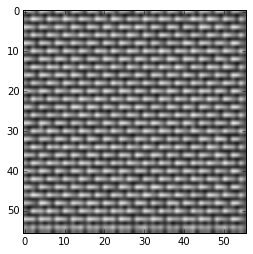

In [27]:
%matplotlib inline
sample_zmb = floatX(np_rng.uniform(-1., 1., size=(100, nz)))
samples = np.asarray(_gen(sample_zmb))
plt.imshow(samples[0].reshape(56,56),'gray')

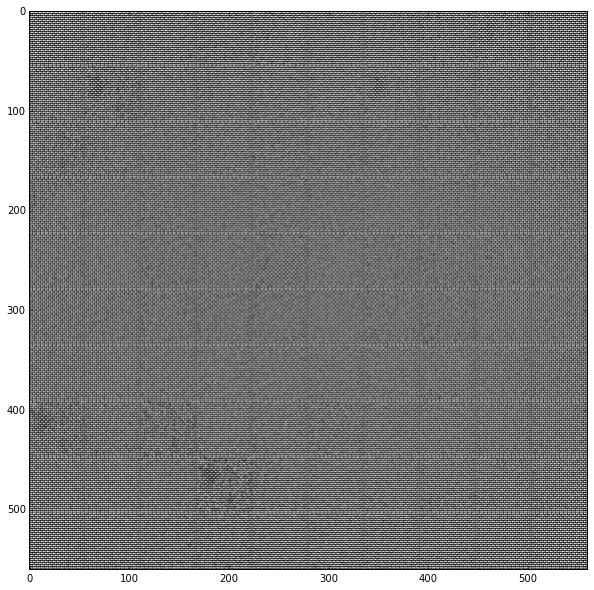

In [28]:
n = 10  # figure with 15x15 digits
digit_size = 56
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np_rng.uniform(-1., 1., size=(100, nz))
        z_sample=z_sample.astype(np.float32)
        x_decoded = _gen(z_sample)[0]
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

(array([ 573.,   10.,   10.,    8.,   16.,    7.,    5.,   13.,   14.,  128.]),
 array([  4.62138674e-19,   9.99975324e-02,   1.99995065e-01,
          2.99992597e-01,   3.99990129e-01,   4.99987662e-01,
          5.99985194e-01,   6.99982727e-01,   7.99980259e-01,
          8.99977791e-01,   9.99975324e-01]),
 <a list of 10 Patch objects>)

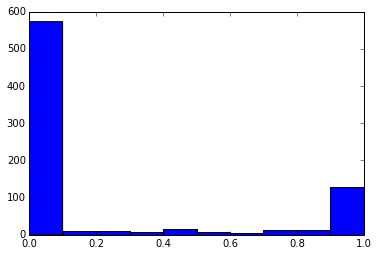

In [128]:
plt.hist(x_decoded.reshape(-1))